<h1 style='text-align:center; background-color:darkgreen; color:white; padding:10px'>IMDB DataSet from Kaggle</h1>

In [1]:
#IMPORT LIBRARIES
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

In [2]:
#Getting the dataset's Path in the "files" directory
for root, dirs, files in os.walk('files'):
    for file in files:
        print(os.path.join(root, file))

files\IMDb_All_Genres_etf_clean1.csv
files\imdb_threshed.csv
files\netflix_titles.csv
files\.ipynb_checkpoints\IMDb_All_Genres_etf_clean1-checkpoint.csv
files\.ipynb_checkpoints\imdb_threshed-checkpoint.csv


In [2]:
#Reading data to a Pandas DataFrame
#na_values = Strings that should be considered as null
imdb = pd.read_csv('files\IMDb_All_Genres_etf_clean1.csv', na_values=['', '-'])

<h2 style='text-align:center; background-color:darkgreen; color:white; padding:10px'>Preliminary Data analyzes</h2>

In [4]:
imdb.head()

,Movie_Title,Year,Director,Actors,Rating,Runtime(Mins),Censor,Total_Gross,main_genre,side_genre
0,Kantara,2022,Rishab Shetty,"Rishab Shetty, Sapthami Gowda, Kishore Kumar G...",9.3,148,UA,Gross Unkown,Action,"Adventure, Drama"
1,The Dark Knight,2008,Christopher Nolan,"Christian Bale, Heath Ledger, Aaron Eckhart, M...",9.0,152,UA,$534.86M,Action,"Crime, Drama"
2,The Lord of the Rings: The Return of the King,2003,Peter Jackson,"Elijah Wood, Viggo Mortensen, Ian McKellen, Or...",9.0,201,U,$377.85M,Action,"Adventure, Drama"
3,Inception,2010,Christopher Nolan,"Leonardo DiCaprio, Joseph Gordon-Levitt, Ellio...",8.8,148,UA,$292.58M,Action,"Adventure, Sci-Fi"
4,The Lord of the Rings: The Two Towers,2002,Peter Jackson,"Elijah Wood, Ian McKellen, Viggo Mortensen, Or...",8.8,179,UA,$342.55M,Action,"Adventure, Drama"


In [4]:
#shape = rows x columns
imdb.shape

(5562, 10)

In [5]:
#Information
imdb.info()

#Notice: 
    #that there is no null value anyway
    #data types for numeric types are ok except by the Total_Gross (see Total Gross Section Down Below)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5562 entries, 0 to 5561
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Movie_Title    5562 non-null   object 
 1   Year           5562 non-null   int64  
 2   Director       5562 non-null   object 
 3   Actors         5562 non-null   object 
 4   Rating         5562 non-null   float64
 5   Runtime(Mins)  5562 non-null   int64  
 6   Censor         5562 non-null   object 
 7   Total_Gross    5562 non-null   object 
 8   main_genre     5562 non-null   object 
 9   side_genre     5562 non-null   object 
dtypes: float64(1), int64(2), object(7)
memory usage: 434.7+ KB


In [ ]:
#Correlation between columns
imdb.corr()

In [ ]:
#Statistical Information
imdb.describe()

#Notice that although There is no corelation betweem columns, there is a correlation between number of movies and their year. 
#Despite the oldest movie is from 1920, just 25% of them are from before 1997. This will be ilustrated at the chart down below.

In [ ]:
#Duplications
imdb[imdb.duplicated()]

In [ ]:
# Removing duplications
imdb.drop_duplicates(inplace=True)

<h2 style='text-align:center; background-color:darkgreen; color:white; padding:10px'>Visualizations</h2>

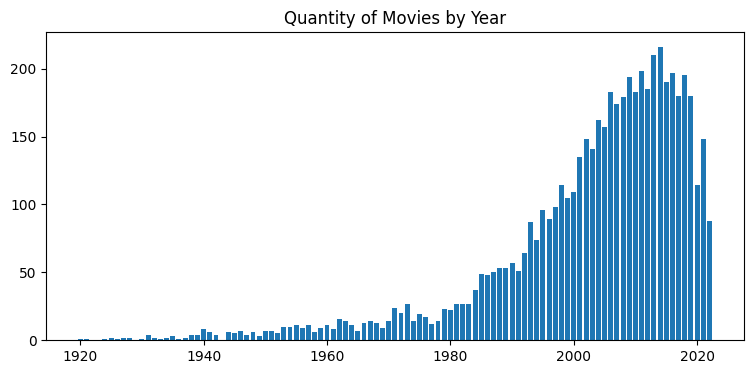

In [6]:
# Chart to show the high quantity of newer movies
plt.figure(num=0, figsize=(9,4))
plt.bar(imdb['Year'].value_counts().index, imdb['Year'].value_counts().values)
plt.title('Quantity of Movies by Year')
plt.show()

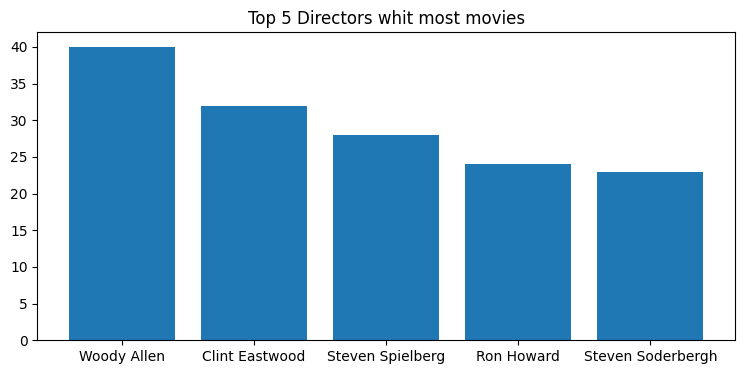

In [7]:
# Top 5 directors in quantity of movies in this data set
plt.figure(figsize=(9,4))
plt.bar(imdb['Director'].value_counts()[:5].index, imdb['Director'].value_counts()[:5].values)
plt.title('Top 5 Directors whit most movies')
plt.show()

In [ ]:
#Top 5 directors in mean rating
top_directors_rt = imdb.groupby('Director')['Rating'].mean().sort_values(ascending=False)[:5]
plt.figure(figsize=(11,4))
plt.bar(top_directors_rt.index, top_directors_rt.values)
plt.title('Top Directors by Mean Rating')
plt.show()

In [ ]:
# TOP Movies by Rating
imdb.sort_values('Rating', ascending=False)[['Movie_Title', 'Rating']][:5]

In [ ]:
# TOP Actors with most appearances
# How I saw that the actors are separeted by comma, thus I first join them all using comma too, then I splited them into a Pandas Series 
# so I can use the value_counts functions to discover they appearances.

actors = imdb['Actors']
pd.Series(', '.join(list(actors)).split(', ')).value_counts()[:5]

<h2 style='text-align:center; background-color:darkgreen; color:white; padding:10px; margin:0px'>Total Gross</h2>
<h3 style='text-align:center; background-color:darkgreen; color:white; padding:10px; margin:0px'>Feature Engineering</h3>

<p>
    <ol>
        <li>First, to order by the total gross, whe have to change the type into a numeric type. As whe can see, there is a dollar sign in the left and a 'M' at the end that probably means Million.</li> 
        <li>Then, lets check if all the rows match this pattern in the step 1. </li>
        <li>Then, lets drop the non-pattern values. Lastly, lets order by the float conversion of the values.</li>
    </ol>
</p>

In [6]:
# Step 1
# We already know that there is no null value.
# Now we know that there is no other possibility: either it are in the patter '$123.45M' or it is 'Gross unknow'

imdb.loc[~imdb['Total_Gross'].str.contains(r'^\$[0-9.]+M$')]['Total_Gross'].unique()

array(['Gross Unkown'], dtype=object)

In [ ]:
#Step 2
#Lets remove the 861 rowns whit the 'Gross Unknow'

gross = imdb.drop(imdb[imdb['Total_Gross'] == 'Gross Unkown'].index)

In [ ]:
# Finaly, lets Sort by the float values

gross.sort_values('Total_Gross', ascending=False, key=lambda x: x.str.extract(r'([0-9.]+)', expand=False).astype(float)).head(5)

In [35]:
# Replacing the total gross type to float (ps: unknow -> 0.0)

imdb.loc[imdb['Total_Gross'] == 'Gross Unkown', 'Total_Gross'] = '0'
imdb['Total_Gross'] = imdb['Total_Gross'].str.replace('$', '').str.replace('M', '')
imdb['Total_Gross'] = imdb['Total_Gross'].astype(float) * 1000000

In [36]:
imdb

,Movie_Title,Year,Director,Actors,Rating,Runtime(Mins),Censor,Total_Gross,main_genre,side_genre
0,Kantara,2022,Rishab Shetty,"Rishab Shetty, Sapthami Gowda, Kishore Kumar G...",9.3,148,UA,0.0,Action,"Adventure, Drama"
1,The Dark Knight,2008,Christopher Nolan,"Christian Bale, Heath Ledger, Aaron Eckhart, M...",9.0,152,UA,534860000.0,Action,"Crime, Drama"
2,The Lord of the Rings: The Return of the King,2003,Peter Jackson,"Elijah Wood, Viggo Mortensen, Ian McKellen, Or...",9.0,201,U,377850000.0,Action,"Adventure, Drama"
3,Inception,2010,Christopher Nolan,"Leonardo DiCaprio, Joseph Gordon-Levitt, Ellio...",8.8,148,UA,292580000.0,Action,"Adventure, Sci-Fi"
4,The Lord of the Rings: The Two Towers,2002,Peter Jackson,"Elijah Wood, Ian McKellen, Viggo Mortensen, Or...",8.8,179,UA,342550000.0,Action,"Adventure, Drama"
...,...,...,...,...,...,...,...,...,...,...
5557,Disaster Movie,2008,"Directors:Jason Friedberg, Aaron Seltzer","Carmen Electra, Vanessa Lachey, Nicole Parker,...",1.9,87,PG-13,14190000.0,Comedy,Sci-Fi
5558,The Hottie & the Nottie,2008,Tom Putnam,"Paris Hilton, Joel David Moore, Christine Laki...",1.9,91,PG-13,30000.0,Comedy,Romance
5559,From Justin to Kelly,2003,Robert Iscove,"Kelly Clarkson, Justin Guarini, Katherine Bail...",1.9,81,PG,4920000.0,Comedy,"Musical, Romance"
5560,Superbabies: Baby Geniuses 2,2004,Bob Clark,"Jon Voight, Scott Baio, Vanessa Angel, Skyler ...",1.5,88,PG,9110000.0,Comedy,"Family, Sci-Fi"


In [37]:
# exporting to csv in order to be used in power bi

imdb.to_csv('./files/imdb_threshed.csv', sep=';', index=False)